In [6]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys 
import re
from ipynb.fs.full.utilities import *
from scipy import signal, fftpack
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter,filtfilt
from operator import add
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
# import all libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew
from matplotlib.patches import Rectangle


In [7]:
# LOADING THE DATASET
fs = 20000 # sampling frequency in Hz
ts = 1/fs  # sampling period in s
n_samples = 2048

data = "/home/jacopo/research/NASA_dataset/2nd_test"

df_list = []
for path,dirs,files in os.walk(data):
    dirs.sort(key=alphanumeric_sort)
    for file in files:
        if file.endswith('.png'):
            continue
        else:
            df = pd.read_csv(os.path.join(path,file),  sep='\t', header=None)
            df.rename(columns={0: 'ch_1', 1: 'ch_2', 2: 'ch_3', 3: 'ch_4'}, inplace = True)  # renaming the columns
            n_samples = df.shape[0]
            time = np.linspace(0, n_samples*ts, num=n_samples, endpoint=False, axis=0)
            if(df.shape[0] != 20480):
                print("different size!")       # checking that all dataseries has the same number of datapoints 
            df['time'] = time
            df_list.append(df)
# each dataseries has 4 accellerometer channel and one temporal channel, lasting for 1 seconds
# each time series has 20480 samples

# performed a check for guarantee that all the elements inside the list of dataframe are composed of different data

In [9]:
# FFT over the signals in input

n = len(df_list[0])

xf = np.fft.fftfreq(n, d=ts)[0:n//2]
yf_list = []
xf_list = []  
start_interval = 2000
finish_interval = 6000            

for elem in df_list[0].columns.values:
    yf_list_ch = []
    xf_list_ch = []

    if elem != 'time': 
        for k in range(len(df_list)):
            yf = df_list[k][elem].to_numpy()
            yf = fft(yf)[0:n//2]
            yf_abs = np.abs(yf) 
            # indices = yf_abs > (0.1*yf_abs.max())   # filter out those value under 300
            # yf_clean = indices * yf_abs
            
            yf_list_ch.append(yf_abs[start_interval:finish_interval])
            xf_list_ch.append(xf[start_interval:finish_interval])
            
   
        yf_list.append(yf_list_ch)
        xf_list.append(xf_list_ch)
        

In [10]:
# split into equidistant interval and features description of such intervals; then Kmeans clustering over the features matrix created in this way
n_split = 50
track_index = 1000*np.arange(n_split)
var = True
max_list = []

print("possible divisor for equidistant intervals: {}".format(getDivs(len(yf_list[0][trial]))))
for p in range(len(yf_list)):
    list_ch = []
    for i in range(len(yf_list[p])):
        if(var):
            ts = yf_list[p][i]
            try:
                split_list = np.split(ts, n_split)    # split into 10 equivalent intervals; each of them have 1024 samples
                var = True
            except:
                print("skipping interval division by {}".format(n_split))
                var = False
                break
        max_array = [np.max(split_list[k]) for k in range(len(split_list))]
        mean_array = [np.mean(split_list[k]) for k in range(len(split_list))]
        std_array = [np.std(split_list[k]) for k in range(len(split_list))]
        kurtosis_array = [kurtosis(split_list[k], fisher=False) for k in range(len(split_list))]
        skew_array = [skew(split_list[k]) for k in range(len(split_list))]
        list_ch.append([max_array+mean_array+std_array+kurtosis_array+skew_array])

    max_list.append(list_ch)
    
if var:        
    X = []
    for p in range(len(max_list)):
        for j in range(len(max_list[p])):
            X.append(np.array(max_list[p][j])) 
                
X = np.array(X) 
X = X.reshape(X.shape[0], X.shape[2])
kmeans_result = KMeans(init="k-means++", n_clusters=2, max_iter=10000, algorithm='elkan').fit(X)
kmeans_split = np.split(kmeans_result.labels_, 4)

possible divisor for equidistant intervals: [1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 800, 1000, 2000, 4000]


Text(0.5, 0.98, 'clustering on the accelerometers - 50 intervals used')

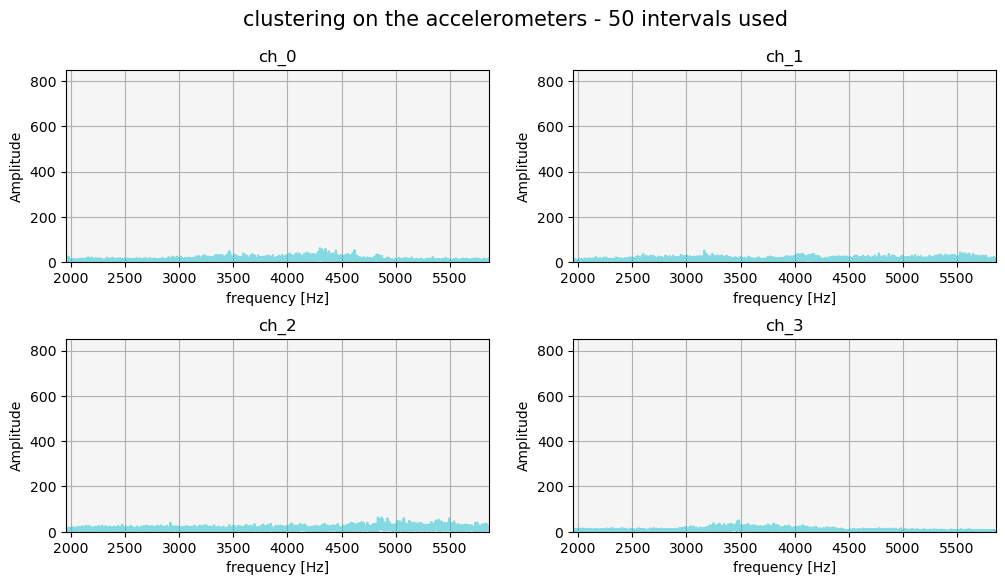

In [20]:
# plotting the final clustering result

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace = 0.4)
xlim = [xf_list[0][0][0], xf_list[0][0][len(xf_list[0][0])-1]]
ylim = [0, 850]

plt.setp(ax, xlim=xlim, ylim=ylim)

ts = 0

ax[0,0].set_title("ch_" + str(0))
ax[0,0].set_xlabel('frequency [Hz]')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].grid(True)
ax[0,0].set_facecolor('whitesmoke')

ax[0,1].set_title("ch_" + str(1))
ax[0,1].set_xlabel('frequency [Hz]')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].grid(True)
ax[0,1].set_facecolor('whitesmoke')

ax[1,0].set_title("ch_" + str(2))
ax[1,0].set_xlabel('frequency [Hz]')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].grid(True)
ax[1,0].set_facecolor('whitesmoke')

ax[1,1].set_title("ch_" + str(3))
ax[1,1].set_xlabel('frequency [Hz]')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].grid(True)
ax[1,1].set_facecolor('whitesmoke')

if(kmeans_split[0][ts] == 0):
    ax[0,0].plot(xf_list[0][ts], yf_list[0][ts], color='tab:cyan', alpha=0.5)
else: 
    ax[0,0].plot(xf_list[0][ts], yf_list[0][ts], color='tab:red', alpha=0.5)
    
if(kmeans_split[1][ts] == 0):
    ax[0,1].plot(xf_list[1][ts], yf_list[1][ts], color='tab:cyan', alpha=0.5)
else: 
    ax[0,1].plot(xf_list[1][ts], yf_list[1][ts], color='tab:red', alpha=0.5)
    
if(kmeans_split[2][ts] == 0):
    ax[1,0].plot(xf_list[2][ts], yf_list[2][ts], color='tab:cyan', alpha=0.5)
else: 
    ax[1,0].plot(xf_list[2][ts], yf_list[2][ts], color='tab:red', alpha=0.5)
    
if(kmeans_split[3][ts] == 0):
    ax[1,1].plot(xf_list[3][ts], yf_list[3][ts], color='tab:cyan', alpha=0.5)
else: 
    ax[1,1].plot(xf_list[3][ts], yf_list[3][ts], color='tab:red', alpha=0.5)
    
fig.suptitle("clustering on the accelerometers - " + str(n_split) + ' intervals used', fontsize = 15)